In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib widget 
from IPython.display import clear_output
import IPython
from io import StringIO
import PIL
import os

In [42]:
# Requirements
!pip install Pillow
!pip install ipympl
!pip install scipy!
!pip install scipy==1.1.0

In [8]:
# Please setup following variables:
video_path = os.getenv('BC_DEMO_VIDEO_PATH') # path to *.mp4 file
xml_path   = os.getenv('BACKGROUND_MATTING_MODEL') # path to xml file
bin_path   = xml_path[:-3]+'bin'
nn_id      = 'background-matting'

In [9]:
# Grab first frame from video in order to get its size
cap = cv.VideoCapture(video_path)
read, frame = cap.read()
assert read
frame.shape
in_size = frame.shape[:2][::-1]

In [10]:
# NN model output has 4 dimmenstions, but OpenCV functions is working with images that are usualy 3D,
# so need to adopt model output for OpenCV image format. This is a an example how to user can implemenent and integrate
# its own operation and kernel.
@cv.gapi.op('custom.tensor2img', in_types=[cv.GMat], out_types=[cv.GMat])
class GTensorToImg:
    """Remove batch dimmension from 4D tensor"""
    @staticmethod
    def outMeta(desc):
        return cv.GMatDesc(desc.depth, desc.dims[1], (desc.dims[3], desc.dims[2]))
    
@cv.gapi.kernel(GTensorToImg)
class GTensorToImgImpl:
    """Implementation for GTensorToImg operation."""
    
    @staticmethod
    def run(tensor):
        return tensor.reshape((tensor.shape[2], tensor.shape[3]))

In [11]:
# Let's descrive our algorithm
blur_sz = (30, 30)
# Infer the model
g_in = cv.GMat()
g_nn_ins = cv.GInferInputs()
g_nn_ins.setInput('input', g_in)
g_nn_outs = cv.gapi.infer(nn_id, g_nn_ins)
g_nn_out = g_nn_outs.at('output')

# Post processing
g_alpha    = cv.gapi.resize(GTensorToImg.on(g_nn_out), in_size)
g_alpha3   = cv.gapi.merge3(g_alpha, g_alpha, g_alpha)
g_bgr      = cv.gapi.blur(cv.gapi.resize(g_in, in_size), blur_sz)
g_in_fp    = cv.gapi.convertTo(g_in, cv.CV_32F)
g_bgr_fp   = cv.gapi.convertTo(g_bgr, cv.CV_32F)
g_one      = cv.GScalar((1.0, 1.0, 1.0))
g_out_fp   = cv.gapi.add(cv.gapi.mul(g_alpha3, g_in_fp),
                         cv.gapi.mul(cv.gapi.subRC(g_one, g_alpha3), g_bgr_fp))
g_out = cv.gapi.convertTo(g_out_fp, cv.CV_8U)

In [12]:
nn_params = cv.gapi.ie.params(nn_id, xml_path, bin_path, 'CPU')
pipeline  = cv.GComputation(g_in, g_out).compileStreaming(cv.gapi.compile_args(cv.gapi.networks(nn_params),
                                                                               cv.gapi.kernels(GTensorToImgImpl)))

[ INFO:0@13.991] global /home/atalaman/workspace/opencv/modules/videoio/src/videoio_registry.cpp (228) VideoBackendRegistry VIDEOIO: Enabled backends(9, sorted by priority): FFMPEG(1000); GSTREAMER(990); INTEL_MFX(980); V4L2(970); CV_IMAGES(960); CV_MJPEG(950); FIREWIRE(940); UEYE(930); OBSENSOR(920)
[ INFO:0@23.022] global /home/atalaman/workspace/opencv/modules/gapi/src/compiler/passes/kernels.cpp (258) expandKernels Final graph: 28 nodes

[ INFO:0@91.449] global /home/atalaman/workspace/opencv/modules/gapi/src/compiler/passes/kernels.cpp (258) expandKernels Final graph: 28 nodes

[ INFO:0@91.494] global /home/atalaman/workspace/opencv/modules/gapi/src/compiler/passes/exec.cpp (638) fuseGeneral island_#0x29eaa30 can be merged into island_#0xdb3640
[ INFO:0@91.495] global /home/atalaman/workspace/opencv/modules/gapi/src/compiler/passes/exec.cpp (656) fuseGeneral merge(island_#0xdb3640,island_#0x29eaa30) was successful!
[ INFO:0@91.495] global /home/atalaman/workspace/opencv/modules/ga

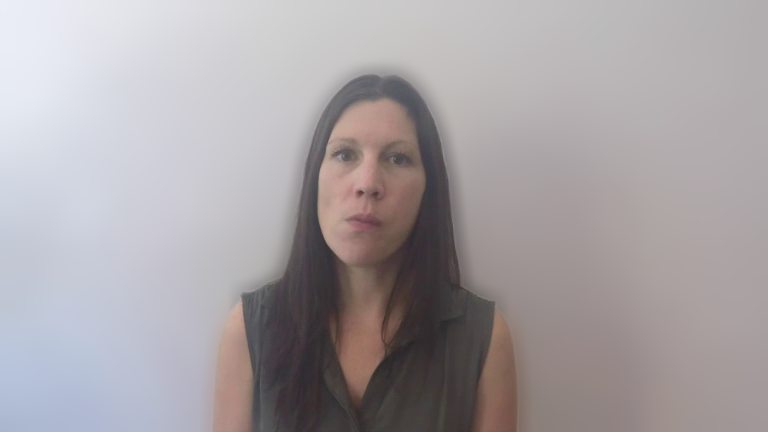

In [ ]:
try:
    pipeline.setSource(cv.gin(cv.gapi.wip.make_capture_src(video_path)))
    pipeline.start()
    while True:
        read, output = pipeline.pull()
        if not read:
            break
            
        display(PIL.Image.fromarray(cv.cvtColor(output, cv.COLOR_BGR2RGB)))
        clear_output(wait=True)
except KeyboardInterrupt:
    pipeline.stop()
    print('Execution is stopped')